In [1]:
"""
Purpose of this notebook is to build a DCGAN, or Deep Convolutional Generative Adversarial Network
"""

'\nPurpose of this notebook is to build a DCGAN, or Deep Convolutional Generative Adversarial Network\n'

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os
import time

In [2]:
# first we'll import the training data we will be using
 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_full = np.concatenate((x_train, x_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
# Normalize images to [-1, 1]
x_full = (x_full.astype('float32') - 127.5) / 127.5

# Shuffle the dataset
buffer_size = 60000
batch_size = 128

# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices(x_full).shuffle(buffer_size).batch(batch_size, drop_remainder=True)


In [4]:
"""
A deep convolutional generative adversarial network (DCGAN) consists of two competing neural networks:
    1. Generator: takes random noise as input and generates images resembling training data
    2. Discriminator: evaluates whether an input image is real or not
These two compete against each other and in theory as the discriminator gets better at 
distinguishing between real and fake, the generator should get better at producing fakes. 
In essence, it is an escalating arms race.
"""

'\nA deep convolutional generative adversarial network (DCGAN) consists of two competing neural networks:\n    1. Generator: takes random noise as input and generates images resembling training data\n    2. Discriminator: evaluates whether an input image is real or not\nThese two compete against each other and in theory as the discriminator gets better at \ndistinguishing between real and fake, the generator should get better at producing fakes. \nIn essence, it is an escalating arms race.\n'

In [5]:
from tensorflow.keras import layers

def build_generator():
    model = tf.keras.Sequential(name='Generator')
    
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 4, 512)))  # 4x4x512

    model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())  # 8x8x256

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())  # 16x16x128

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())  # 32x32x64

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding='same', use_bias=False, activation='tanh'))  # 32x32x3

    return model

generator = build_generator()
generator.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,159,360 (19.68 MB)

 Trainable params: 5,142,080 (19.62 MB)

 Non-trainable params: 17,280 (67.50 KB)

In [6]:
def build_discriminator():
    model = tf.keras.Sequential(name='Discriminator')
    
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32,32,3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # No activation; logits output

    return model

discriminator = build_discriminator()
discriminator.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033,345 (3.94 MB)

 Trainable params: 1,033,345 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real labels = 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake labels = 0
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Generator tries to make fake_output=1

# Define Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
# Directory to save generated images
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Create checkpoint
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Seed for generating images
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        img = (predictions[i] + 1) / 2.0  # Rescale to [0,1]
        plt.imshow(img.numpy())
        plt.axis('off')

    plt.savefig(f'generated_image_epoch_{epoch}.png')
    plt.close()

def train(dataset, epochs):
    for epoch in range(1, epochs+1):
        start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        # Produce images for the GIF as we go
        generate_and_save_images(generator, epoch, seed)

        # Save the model every 10 epochs
        if (epoch) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print(f'Epoch {epoch}, Generator Loss: {tf.reduce_mean(gen_loss_list):.4f}, '
              f'Discriminator Loss: {tf.reduce_mean(disc_loss_list):.4f}, '
              f'Time: {time.time()-start:.2f} sec')

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)
epochs = 50
train(dataset, epochs)

2024-09-24 22:47:48.116022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1, Generator Loss: 6.0334, Discriminator Loss: 0.4177, Time: 36.88 sec
Epoch 2, Generator Loss: 4.1317, Discriminator Loss: 0.2899, Time: 28.87 sec
Epoch 3, Generator Loss: 4.4376, Discriminator Loss: 0.2940, Time: 29.14 sec
Epoch 4, Generator Loss: 4.1250, Discriminator Loss: 0.2792, Time: 28.89 sec
Epoch 5, Generator Loss: 3.5793, Discriminator Loss: 0.3635, Time: 28.88 sec
Epoch 6, Generator Loss: 3.8394, Discriminator Loss: 0.2383, Time: 28.89 sec
Epoch 7, Generator Loss: 4.3438, Discriminator Loss: 0.2487, Time: 28.87 sec
Epoch 8, Generator Loss: 4.3896, Discriminator Loss: 0.2140, Time: 29.15 sec
Epoch 9, Generator Loss: 4.6160, Discriminator Loss: 0.2243, Time: 28.89 sec
Epoch 10, Generator Loss: 4.5770, Discriminator Loss: 0.1790, Time: 29.16 sec
Epoch 11, Generator Loss: 4.2491, Discriminator Loss: 0.2527, Time: 28.88 sec
Epoch 12, Generator Loss: 4.4814, Discriminator Loss: 0.2204, Time: 28.88 sec
Epoch 13, Generator Loss: 4.7761, Discriminator Loss: 0.1543, Time: 28.89

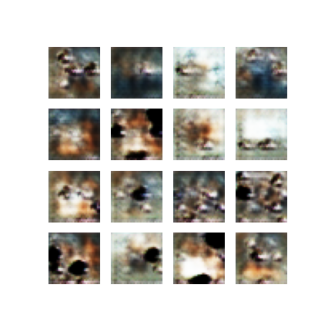

In [9]:
def display_images(epoch):
    plt.figure(figsize=(4,4))
    for i in range(num_examples_to_generate):
        img = plt.imread(f'generated_image_epoch_{epoch}.png')
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Example: Display images from epoch 50
display_images(50)
